I start with looking at a sample image from the dataset in order to figure out preprocessing steps. The main reason for preprocessing is focus on the area of interest in the image and discard the rest.
Based on the sample image in the following cell, I discard top 1/3 of the image and bottom 20 rows, which is dashboard.
The I reduce imagesize to 64 x 64.

image shape:  (160, 320, 3)


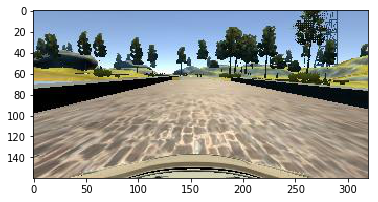

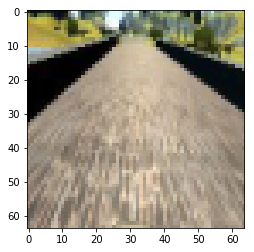

In [1]:
import os
import numpy as np
import cv2
import pickle
import matplotlib.pyplot as plt
import math

# Visualizations will be shown in the notebook.
%matplotlib inline

new_size_col,new_size_row = 64, 64
def preprocessImage(image):
    shape = image.shape
    # note: numpy arrays are (row, col)!
    image = image[math.floor(shape[0]/3):shape[0]-20, 0:shape[1]]
    image = cv2.resize(image,(new_size_col,new_size_row),interpolation=cv2.INTER_AREA)    
    return image

i = 0
indir = 'Data/IMG'

for roots,dirs,filenames in os.walk(indir):
    for f in filenames:
        fullpath = os.path.join(indir,f)
        if '.jpg' in fullpath:
            x=plt.imread(fullpath)
            #X_test[i,:,:,:] = cv2.resize(x,(32, 32),interpolation = cv2.INTER_AREA)
            i+=1
            plt.figure(i)
            plt.imshow(x)
            print('image shape: ',x.shape)
            break

plt.figure(2)
plt.imshow(preprocessImage(x))

Now that I determined preprocessing steps from sample image, I applied it to the whole dataset. Also, I included images from left and right cameras by adding/subtracting 0.5 offset to the corresponding center image.
Note that the value of 0.5 offset is a final value that was determined after several trial values that I started with 0.25, then 0.3. and 0.4.

Also, during the course of training the network and then testing it on the track, I found that vehicle is biased toward zero steering angle since lot of dataset contains zero/low value steering angle. So I exclued images with steering angel < 0.1 from the training set.

In [ ]:
new_size_col,new_size_row = 64, 64
def preprocessImage(image):
    shape = image.shape
    # note: numpy arrays are (row, col)!
    image = image[math.floor(shape[0]/3):shape[0]-20, 0:shape[1]]
    image = cv2.resize(image,(new_size_col,new_size_row),interpolation=cv2.INTER_AREA)    
    return image

train_center = pd.read_csv('Data/driving_log.csv', usecols=['center','steering'])
train_left = pd.read_csv('Data/driving_log.csv', usecols=['left','steering'])
train_right = pd.read_csv('Data/driving_log.csv', usecols=['right','steering'])

#Add offest to left and right steering images
train_left['steering'] = train_left['steering'] + 0.5
train_right['steering'] = train_right['steering'] - 0.5

def preprocessImage(image):
    shape = image.shape
    # note: numpy arrays are (row, col)!
    image = image[math.floor(shape[0]/3):shape[0]-20, 0:shape[1]]
    image = cv2.resize(image,(new_size_col,new_size_row),interpolation=cv2.INTER_AREA)
    image = (image-127.5)/255
    return image

samples = train_center.shape[0]
X_traint = np.empty([3*samples,64,64,3])
y_traint = np.empty([3*samples,1])

idx = -1
indir = 'Data'

for i in range(samples):
    if np.absolute(train_center.loc[i][1]) > 0.1:
        fullpath = os.path.join(indir,train_center.loc[i][0][0:])        
        x=plt.imread(fullpath)
        idx = idx+1
        X_traint[idx,:,:,:] = preprocessImage(x)
        y_traint[idx] = train_center.loc[i][1]
    if np.absolute(train_left.loc[i][1]) > 0.1:
        fullpath = os.path.join(indir,train_left.loc[i][0][1:])        
        x=plt.imread(fullpath)
        idx = idx+1
        X_traint[idx,:,:,:] = preprocessImage(x)
        y_traint[idx] = train_left.loc[i][1]
    if np.absolute(train_right.loc[i][1]) > 0.1:    
        fullpath = os.path.join(indir,train_right.loc[i][0][1:])        
        x=plt.imread(fullpath)
        idx = idx+1
        X_traint[idx,:,:,:] = preprocessImage(x)
        y_traint[idx] = train_right.loc[i][1]

# squeeze out zero data
X_train = X_traint[0:idx]
y_train = y_traint[0:idx]
        
X_train, y_train = shuffle(X_train, y_train)

#save training data so it can be interated/tried with different network combinations
np.save('Training_Images_0',X_train)
np.save('Training_Labels_0',y_train)

In [2]:
import os
import numpy as np
import cv2
import pickle
import matplotlib.pyplot as plt
import math
import pandas as pd
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer

#load original training data
X_train = np.load('Training_Images_0.npy')
y_train = np.load('Training_Labels_0.npy') 

**Network Design**
This is one of the most time consuming phase of the project. What you see below is the final result after lot of iterations over design of the network.

I started with a network described by Vivek Yadav at https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9#.t4dg5fiez.
It consisted of three convolution network followed by three fully connected ones. So I started with that design by that network has more than 4 million parameters and was trained on GPU machine, which I didn't have. I trained that network with original dataset as well as lot of augmented images but it was taking too long on my CPU machine. 

So, after few days of playing with it, I started experimenting with design of the network. I first removed a large fully-connected layer to reduce parameters. I also, remove dropout layers because I didn't have as much training data as was used by original author. So Overfitting was not a problem but underfitting of huge number of parameters was a concern for me.

I also tried various combination of convolution layer sizes, fully connected layer sizes and activation functions and settled on the network design presented below. It has three colvolution layers followed by pooling layers and ELUs. ELUs enable faster learning than ReLUs in DNNs.(source:https://arxiv.org/pdf/1511.07289v1.pdf). As, the training dataset was not massive (only few thousand images), faster learing was of more importance to me. After the last convnet layer, I used two fully-connected layers to tranform image data to steering angle. Use of LeakyReLU in the last layer was to smoothen the steering angle changes.

Also, I was able to increase learning angle by a factor 10 from the original design and still get good enough results.

In [6]:
import argparse
import json
from keras.models import model_from_json
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda
from keras.layers.advanced_activations import ELU, LeakyReLU
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D


model = Sequential()
model.add(Convolution2D(32, 3, 3, input_shape=(64, 64, 3),border_mode="valid"))
model.add(MaxPooling2D((2, 2)))
#model.add(Dropout(0.5))
model.add(ELU())
model.add(Convolution2D(64, 3, 3,border_mode="valid"))
model.add(MaxPooling2D((2, 2)))
#model.add(Dropout(0.5))
model.add(ELU())
model.add(Convolution2D(64, 3, 3,border_mode="valid"))
model.add(MaxPooling2D((2, 2)))
#model.add(Dropout(0.5))
model.add(ELU())
model.add(Flatten())
model.add(Dense(64))
model.add(ELU())
model.add(Dense(16))
model.add(LeakyReLU())
model.add(Dense(1))

adam1 = Adam(lr=0.001)

model.compile(optimizer=adam1, loss="mse",metrics=['accuracy'])
model.summary()
history = model.fit(X_train, y_train, nb_epoch=5, validation_split=0.1)


# saving model
json_model = model.to_json()
open('model_ver4.json', 'w').write(json_model)
# saving weights
model.save_weights('model_ver4.h5', overwrite=True)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_9 (Convolution2D)  (None, 62, 62, 32)    896         convolution2d_input_4[0][0]      
____________________________________________________________________________________________________
maxpooling2d_9 (MaxPooling2D)    (None, 31, 31, 32)    0           convolution2d_9[0][0]            
____________________________________________________________________________________________________
elu_12 (ELU)                     (None, 31, 31, 32)    0           maxpooling2d_9[0][0]             
____________________________________________________________________________________________________
convolution2d_10 (Convolution2D) (None, 29, 29, 64)    18496       elu_12[0][0]                     
___________________________________________________________________________________________

**Recovery Data** At this point, the car was able to drive first half of the track but would veer off the track after bridge and go to the dirt patch.

So I collected recovery data by deliberately driving car to beyond the lane markers and then towards the center of the lane. I collected several datapoints of recovery driving. This data should make car less suseptible to sharp turns.


In [8]:
from keras.models import model_from_json
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.utils import shuffle
import math
import os

import pandas as pd
train_center = pd.read_csv('Track1_Recovery/driving_log.csv', usecols=['center','steering'])
train_left = pd.read_csv('Track1_Recovery/driving_log.csv', usecols=['left','steering'])
train_right = pd.read_csv('Track1_Recovery/driving_log.csv', usecols=['right','steering'])

#label_center = np.float16(train_center.as_matrix(columns=['steering']))
#label_left = np.float16(train_left.as_matrix(columns=['steering'])) + 0.25
#label_right = np.float16(train_right.as_matrix(columns=['steering'])) - 0.25

train_left['steering'] = train_left['steering'] + 0.5
train_right['steering'] = train_right['steering'] - 0.5

new_size_col,new_size_row = 64, 64
def preprocessImage(image):
    shape = image.shape
    # note: numpy arrays are (row, col)!
    image = image[math.floor(shape[0]/3):shape[0]-20, 0:shape[1]]
    image = cv2.resize(image,(new_size_col,new_size_row),interpolation=cv2.INTER_AREA)
    image = (image-127.5)/255
    return image

# arrange training data

i = 0
indir = 'Track1_Recovery'

samples = train_center.shape[0]


X_train = np.empty([3*samples,64,64,3])
y_train = np.empty([3*samples,1])

for i in range(samples):
    fullpath = os.path.join(indir,train_center.loc[i][0][0:])        
    x=plt.imread(fullpath)
    X_train[i,:,:,:] = preprocessImage(x)
    y_train[i] = train_center.loc[i][1]
    fullpath = os.path.join(indir,train_left.loc[i][0][1:])        
    x=plt.imread(fullpath)
    X_train[i+samples,:,:,:] = preprocessImage(x)
    y_train[i+samples] = train_left.loc[i][1]
    fullpath = os.path.join(indir,train_right.loc[i][0][1:])        
    x=plt.imread(fullpath)
    X_train[i+2*samples,:,:,:] = preprocessImage(x)
    y_train[i+2*samples] = train_right.loc[i][1]

print(X_train.shape)
print(y_train.shape)

X_train, y_train = shuffle(X_train, y_train)

model = model_from_json(open('model_ver4.json').read())
model.load_weights('model_ver4.h5')
adam1 = Adam(lr=0.001)
model.compile(optimizer=adam1, loss="mse",metrics=['accuracy'])

history = model.fit(X_train, y_train, nb_epoch=5, validation_split=0.1)
# saving model
json_model = model.to_json()
open('model_ver4.json', 'w').write(json_model)
# saving weights
model.save_weights('model_ver4.h5', overwrite=True)


(2577, 64, 64, 3)
(2577, 1)
Train on 2319 samples, validate on 258 samples
Epoch 1/5
2319/2319 [==============================] - 25s - loss: 0.1548 - acc: 0.2143 - val_loss: 0.1313 - val_acc: 0.1977

**Augmented Data** Actually, adding the car recovery data made car more unstable i.e. it would tend to go off the track and get stuck. This wasn't consistent behaviour. It would happen on some laps and other laps, it wouldn't.
So I decided to train the network with augmented data. The augmentation is to flip an original image and assign negative steering angle to the flipped image. This should simulate driving in other direction, making steering action more robust to turns and reduce overfitting.

I used Keras built-in generator function to simultaenously generate augmented data and train the network

In [ ]:
from keras.models import model_from_json
import json
import numpy as np
import cv2
import pickle
from keras.models import Sequential
from keras.optimizers import Adam


def generate_data(image,angle,batch_size):
    a = len(image)
    batch_train = np.zeros((batch_size, 64, 64, 3), dtype = np.float32)
    batch_angle = np.zeros((batch_size,), dtype = np.float32)
    while 1:
        for i in range(batch_size):
            idx = np.random.randint(a)
            batch_train[i] = cv2.flip(image[idx],1)
            batch_angle[i] = -angle[idx]
        yield batch_train, batch_angle

#load original training data
X_train = np.load('Training_Images_0.npy')
y_train = np.load('Training_Labels_0.npy') 

In [4]:
flip_train_data = generate_data(X_train,y_train,512)

#load model
model = model_from_json(open('model_ver4.json').read())
model.load_weights('model_ver4.h5')
adam1 = Adam(lr=0.001)

#compile and train
model.compile(optimizer=adam1, loss="mse",metrics=['accuracy'])
history = model.fit_generator(flip_train_data,samples_per_epoch = 35*512,
                   nb_epoch=5)

# saving model
json_model = model.to_json()
open('model_ver4.json', 'w').write(json_model)
# saving weights
model.save_weights('model_ver4.h5', overwrite=True)

Epoch 1/5
17920/17920 [==============================] - 232s - loss: 0.0453 - acc: 1.1161e-04     

**Track 2**
So far all the training was done for the Track1. Now, we improve the model by training it with Track 2 data so it can perform on Track2

In [5]:
from keras.models import model_from_json
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.utils import shuffle
import math
import os
import pandas as pd

train_center1 = pd.read_csv('Track2_Data/driving_log.csv', usecols=[0,3])
train_left1 = pd.read_csv('Track2_Data/driving_log.csv', usecols=[1,3])
train_right1 = pd.read_csv('Track2_Data/driving_log.csv', usecols=[2,3])

print (train_left1.iloc[2:5,1])
train_left1.iloc[:,1]= train_left1.iloc[:,1] + 0.25
train_right1.iloc[:,1] = train_right1.iloc[:,1] - 0.25

train_center2 = pd.read_csv('Track2_Data/driving_log2.csv', usecols=[0,3])
train_left2 = pd.read_csv('Track2_Data/driving_log2.csv', usecols=[1,3])
train_right2 = pd.read_csv('Track2_Data/driving_log2.csv', usecols=[2,3])

train_left2.iloc[:,1] = train_left2.iloc[:,1] + 0.25
train_right2.iloc[:,1] = train_right2.iloc[:,1] - 0.25

train_center3 = pd.read_csv('Track2_Data/driving_log3.csv', usecols=[0,3])
train_left3 = pd.read_csv('Track2_Data/driving_log3.csv', usecols=[1,3])
train_right3 = pd.read_csv('Track2_Data/driving_log3.csv', usecols=[2,3])

train_left3.iloc[:,1] = train_left3.iloc[:,1] + 0.25
train_right3.iloc[:,1] = train_right3.iloc[:,1] - 0.25

print (train_left3.iloc[1,1])

train_center = pd.concat((train_center1,train_center2))
train_left = pd.concat((train_left1,train_left2))
train_right = pd.concat((train_right1,train_right2))

print(train_center.dtypes)
print(train_center.shape)

2    0.0
3    0.0
4    0.0
Name:  0, dtype: float64
0.25
 0                                                                                                             float64
/Users/Dushyant/Self-Driving NanoDegree/First Term/Behaviour Cloning/IMG/center_2017_01_22_16_00_57_524.jpg     object
/Users/Dushyant/Self-Driving NanoDegree/First Term/Behaviour Cloning/IMG/center_2017_01_22_16_05_02_753.jpg     object
dtype: object
(2830, 3)


In [7]:
from keras.models import model_from_json
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.utils import shuffle
import math
import os
import pandas as pd

train_center = pd.read_csv('Run3_Track2/driving_log.csv', usecols=[0,3])
train_left = pd.read_csv('Run3_Track2/driving_log.csv', usecols=[1,3])
train_right = pd.read_csv('Run3_Track2/driving_log.csv', usecols=[2,3])

print (train_left.iloc[2:5,1])
train_left.iloc[:,1]= train_left.iloc[:,1] + 0.25
train_right.iloc[:,1] = train_right.iloc[:,1] - 0.25

print (train_left.iloc[2:5,1])

2    0.0
3    0.0
4    0.0
Name:  0, dtype: float64
2    0.25
3    0.25
4    0.25
Name:  0, dtype: float64


In [28]:
print(train_center.iloc[1,0][69:80])
print(train_center.loc[1][0][69:80])
print(train_center.loc[1][1])

Run3_Track2
Run3_Track2
0.0


In [30]:
new_size_col,new_size_row = 64, 64
def preprocessImage(image):
    shape = image.shape
    # note: numpy arrays are (row, col)!
    image = image[math.floor(shape[0]/3):shape[0]-20, 0:shape[1]]
    image = cv2.resize(image,(new_size_col,new_size_row),interpolation=cv2.INTER_AREA)
    image = (image-127.5)/255
    return image

samples = train_center.shape[0]
X_traint = np.empty([3*samples,64,64,3])
y_traint = np.empty([3*samples,1])

print(samples)

idx = -1

for i in range(samples):
    if np.absolute(train_center.loc[i][1]) > 0.1:
        fullpath = train_center.loc[i][0][69:]       
        x=plt.imread(fullpath)
        idx = idx+1
        X_traint[idx,:,:,:] = preprocessImage(x)
        y_traint[idx] = train_center.loc[i][1]
    if np.absolute(train_left.loc[i][1]) > 0.1:
        fullpath = train_left.loc[i][0][70:]        
        x=plt.imread(fullpath)
        idx = idx+1
        X_traint[idx,:,:,:] = preprocessImage(x)
        y_traint[idx] = train_left.loc[i][1]
    if np.absolute(train_right.loc[i][1]) > 0.1:    
        fullpath = train_right.loc[i][0][70:]        
        x=plt.imread(fullpath)
        idx = idx+1
        X_traint[idx,:,:,:] = preprocessImage(x)
        y_traint[idx] = train_right.loc[i][1]

# squeeze out zero data
X_train = X_traint[0:idx]
y_train = y_traint[0:idx]

print(X_train.shape)

2967
(6627, 64, 64, 3)


In [31]:
X_train, y_train = shuffle(X_train, y_train)

#save training data so it can be interated/tried with different network combinations
np.save('Training_Img_Track2',X_train)
np.save('Training_Lab_Track2',y_train)

In [32]:
model = model_from_json(open('model_ver4.json').read())
model.load_weights('model_ver4.h5')
adam1 = Adam(lr=0.001)
model.compile(optimizer=adam1, loss="mse",metrics=['accuracy'])

history = model.fit(X_train, y_train, nb_epoch=5, validation_split=0.1)
# saving model
json_model = model.to_json()
open('model_ver4_Track2.json', 'w').write(json_model)
# saving weights
model.save_weights('model_ver4_Track2.h5', overwrite=True)

Train on 5964 samples, validate on 663 samples
Epoch 1/5
5964/5964 [==============================] - 91s - loss: 0.0663 - acc: 0.0017 - val_loss: 0.0666 - val_acc: 0.0000e+00

In [34]:
def generate_data(image,angle,batch_size):
    a = len(image)
    batch_train = np.zeros((batch_size, 64, 64, 3), dtype = np.float32)
    batch_angle = np.zeros((batch_size,), dtype = np.float32)
    while 1:
        for i in range(batch_size):
            idx = np.random.randint(a)
            batch_train[i] = cv2.flip(image[idx],1)
            batch_angle[i] = -angle[idx]
        yield batch_train, batch_angle

flip_train_data = generate_data(X_train,y_train,300)

#compile and train
model.compile(optimizer=adam1, loss="mse",metrics=['accuracy'])
history = model.fit_generator(flip_train_data,samples_per_epoch = 6600,
                   nb_epoch=5)

# saving model
json_model = model.to_json()
open('model_ver4_Track2.json', 'w').write(json_model)
# saving weights
model.save_weights('model_ver4_Track2.h5', overwrite=True)

Epoch 1/5
6600/6600 [==============================] - 86s - loss: 0.4542 - acc: 0.0014          